In [14]:
import matplotlib.pyplot as plt
from NerualOperatorClass import FeedForwardNN, DeepOnet
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

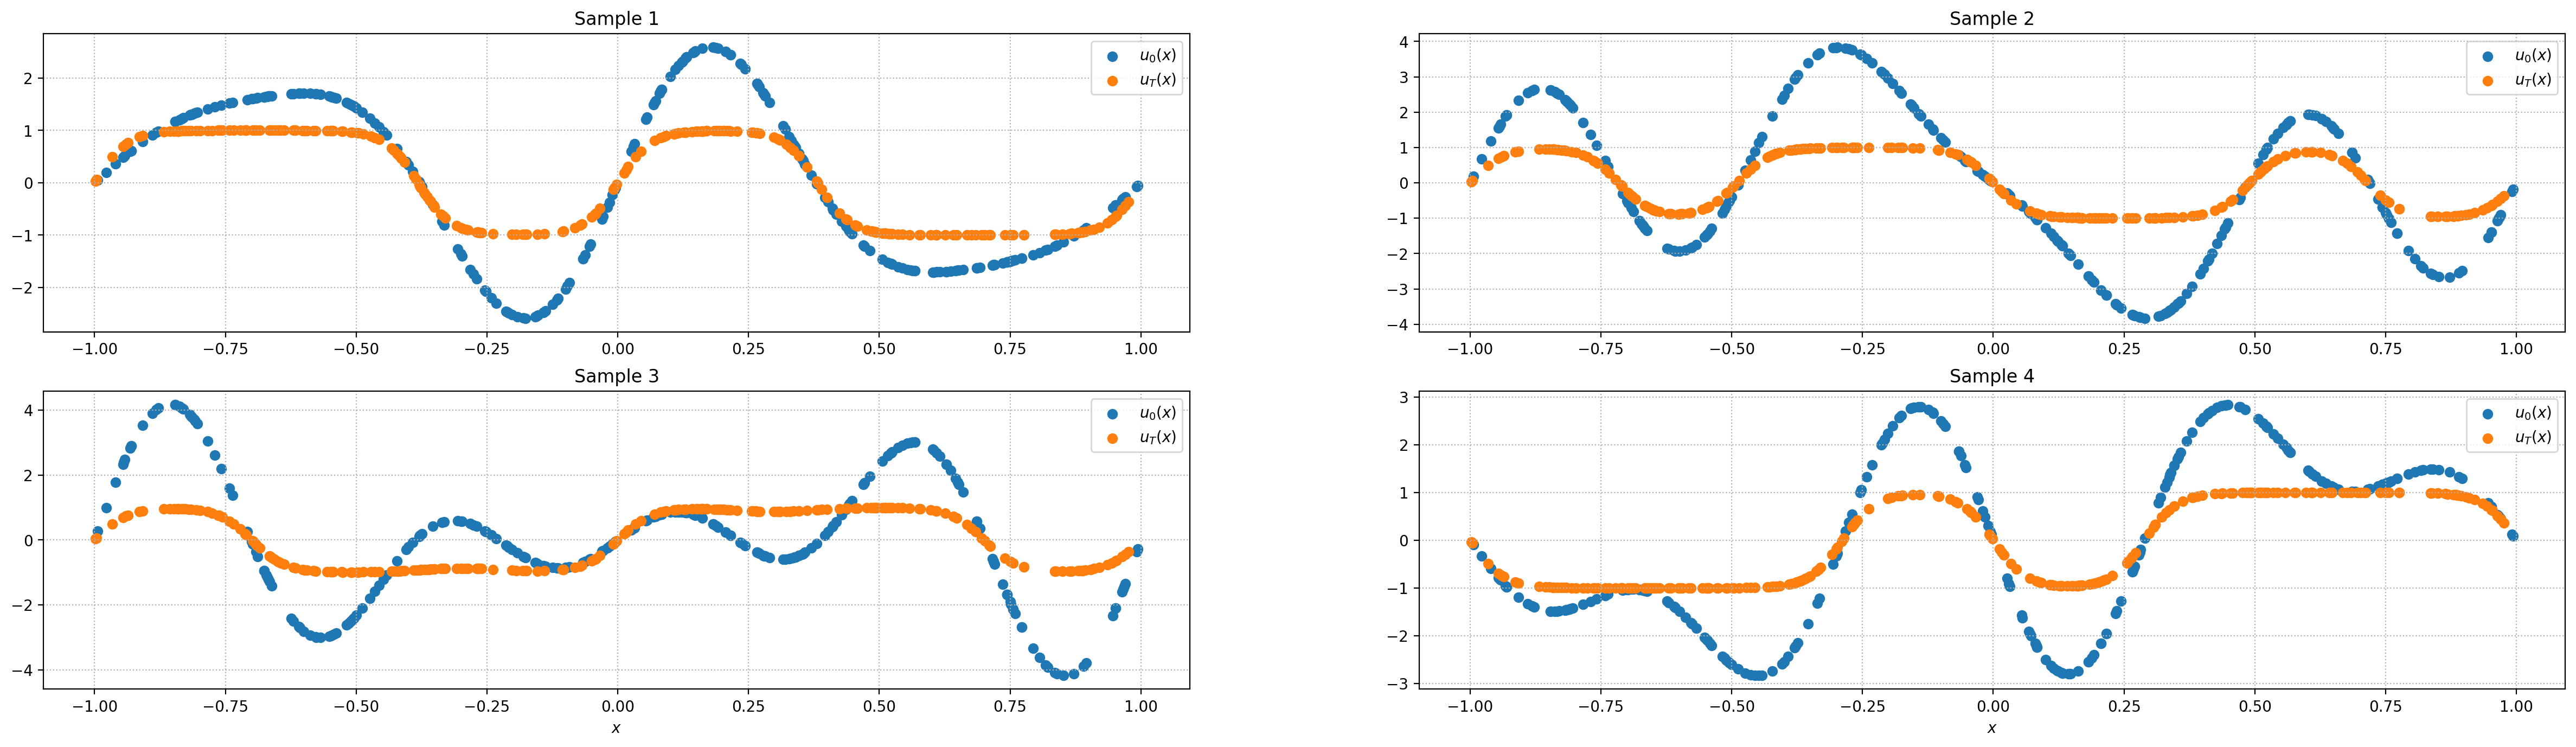

In [15]:
n_train = 500           # Variable L in the notes
n_input_sensor = 250    # Variable m in the notes
n_output_sensor = 250   # Variable n in the notes

# x_data and y_data contains all the input and output function evaluated on a grid with 1001 grid points
input_data = torch.from_numpy(np.load("data/AC_data_input.npy")).type(torch.float32)  # Shape (1000, 1001, 2)
output_data = torch.from_numpy(np.load("data/AC_data_output.npy")).type(torch.float32) # Shape (1000, 1001)
# x_data[:, :, 0] contains the values of the x coordinates where the input functions are evaluated
# x_data[:, :, 1] contains the values of the input functions at the given x coordinates
# y_data contains the values of the output functions at the given x coordinates (same as the coordinates where the input functions are evaluated)

input_sensor_idx = np.random.randint(0, input_data.shape[1], n_input_sensor)
output_sensor_idx = np.random.randint(0, output_data.shape[1], n_output_sensor)

# Randomly select only 250 coordinates where the input and output functions are evaluated. These set of points are different (they correspond to the variables x and y defined in the notes)
# Split train and test data
input_function_train = input_data[:n_train, input_sensor_idx, 1]
output_function_train = output_data[:n_train, output_sensor_idx]

input_function_test = input_data[n_train:, input_sensor_idx, 1]
output_function_test = output_data[n_train:, output_sensor_idx]

# Set of coordinates where output functions are evaluated (variable y in the notes)
y = input_data[0, output_sensor_idx, 0].unsqueeze(1)

fig, axes = plt.subplots(2, 2, figsize=(30, 8), dpi=200)
axes[0, 0].grid(True, which="both", ls=":")
axes[0, 1].grid(True, which="both", ls=":")
axes[1, 0].grid(True, which="both", ls=":")
axes[1, 1].grid(True, which="both", ls=":")

# Set of coordinates where input functions are evaluated (variable x in the notes)
x = input_data[0, input_sensor_idx, 0].unsqueeze(1)

axes[0, 0].scatter(x, input_function_train[0], label=r'$u_0(x)$')
axes[0, 0].scatter(y, output_function_train[0], label=r'$u_T(x)$')

axes[0, 1].scatter(x, input_function_train[1], label=r'$u_0(x)$')
axes[0, 1].scatter(y, output_function_train[1], label=r'$u_T(x)$')

axes[1, 0].scatter(x, input_function_train[2], label=r'$u_0(x)$')
axes[1, 0].scatter(y, output_function_train[2], label=r'$u_T(x)$')

axes[1, 1].scatter(x, input_function_train[3], label=r'$u_0(x)$')
axes[1, 1].scatter(y, output_function_train[3], label=r'$u_T(x)$')
axes[0, 0].set(title="Sample 1")
axes[0, 1].set(title="Sample 2")
axes[1, 0].set(xlabel=r'$x$', title="Sample 3")
axes[1, 1].set(xlabel=r'$x$', title="Sample 4")
axes[0, 0].legend()
axes[0, 1].legend()
axes[1, 0].legend()
axes[1, 1].legend()

In [22]:
# Use feedforward dense NN for branch and trunk
branch_architecture_ = {
    "n_hidden_layers": 4,
    "neurons": 20,
    "act_string": "tanh",
    "retrain": 65
}

trunk_architecture_ = {
    "n_hidden_layers": 6,
    "neurons": 24,
    "act_string": "tanh",
    "retrain": 125
}
# Variable P in the notes (number of basis functions)
n_basis_function = 20

branch = FeedForwardNN(n_input_sensor, n_basis_function, branch_architecture_)
trunk = FeedForwardNN(1, n_basis_function, trunk_architecture_)
deeponet = DeepOnet(branch, trunk)

In [23]:
epochs = 10000
batch_size = 50
freq_print = 100
learning_rate = 0.001
step_size = 2000
gamma = 0.8

training_set = DataLoader(TensorDataset(input_function_train, output_function_train), batch_size=batch_size, shuffle=True)

testing_set = DataLoader(TensorDataset(input_function_train, output_function_train), batch_size=n_train, shuffle=False)

In [24]:
optimizer = torch.optim.Adam(deeponet.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

l = torch.nn.MSELoss()
for epoch in range(epochs):
    train_mse = 0.0
    for step, (input_batch, output_batch) in enumerate(training_set):
        optimizer.zero_grad()
        output_pred_batch = deeponet(input_batch, y)
        loss_f = l(output_pred_batch, output_batch)
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()
    train_mse /= len(training_set)

    scheduler.step()

    with torch.no_grad():
        deeponet.eval()
        test_relative_l2 = 0.0
        for step, (input_batch, output_batch) in enumerate(testing_set):
            output_pred_batch = deeponet(input_batch, y)
            loss_f = (torch.mean((output_pred_batch - output_batch) ** 2) / torch.mean(output_batch ** 2)) ** 0.5 * 100
            test_relative_l2 += loss_f.item()
        test_relative_l2 /= len(testing_set)

    if epoch % freq_print == 0: print("######### Epoch:", epoch, " ######### Train Loss:", round(train_mse, 6), " ######### Relative L2 Test Norm:", round(test_relative_l2, 6))


######### Epoch: 0  ######### Train Loss: 39.490749  ######### Relative L2 Test Norm: 498.211517
######### Epoch: 100  ######### Train Loss: 0.147285  ######### Relative L2 Test Norm: 45.45232
######### Epoch: 200  ######### Train Loss: 0.099242  ######### Relative L2 Test Norm: 38.712154
######### Epoch: 300  ######### Train Loss: 0.06849  ######### Relative L2 Test Norm: 30.90505
######### Epoch: 400  ######### Train Loss: 0.051703  ######### Relative L2 Test Norm: 27.45406
######### Epoch: 500  ######### Train Loss: 0.043491  ######### Relative L2 Test Norm: 24.904507
######### Epoch: 600  ######### Train Loss: 0.035  ######### Relative L2 Test Norm: 22.738392
######### Epoch: 700  ######### Train Loss: 0.028286  ######### Relative L2 Test Norm: 19.459953
######### Epoch: 800  ######### Train Loss: 0.024687  ######### Relative L2 Test Norm: 17.730669
######### Epoch: 900  ######### Train Loss: 0.017965  ######### Relative L2 Test Norm: 15.693691
######### Epoch: 1000  ######### Trai

Relative L2 error:  3.659316062927246


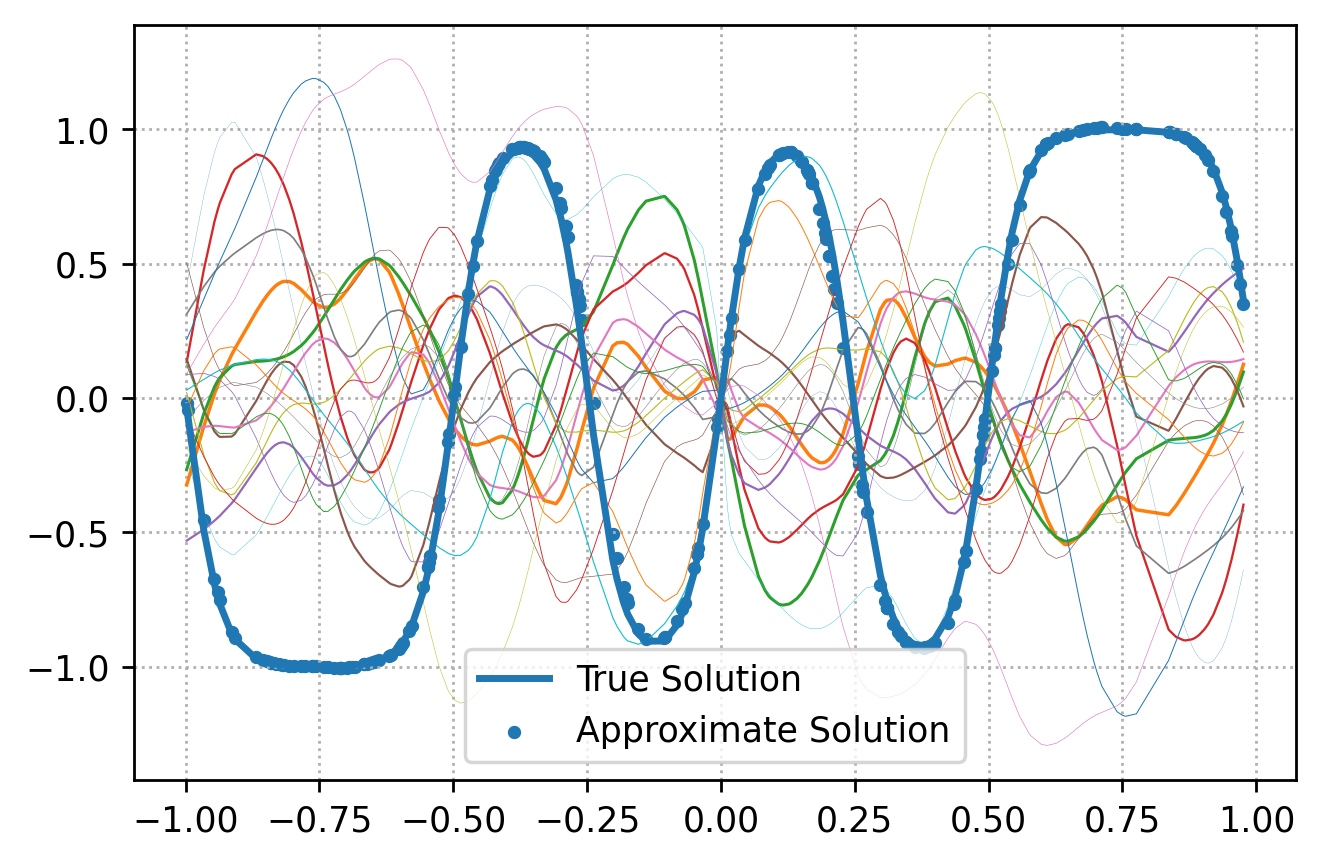

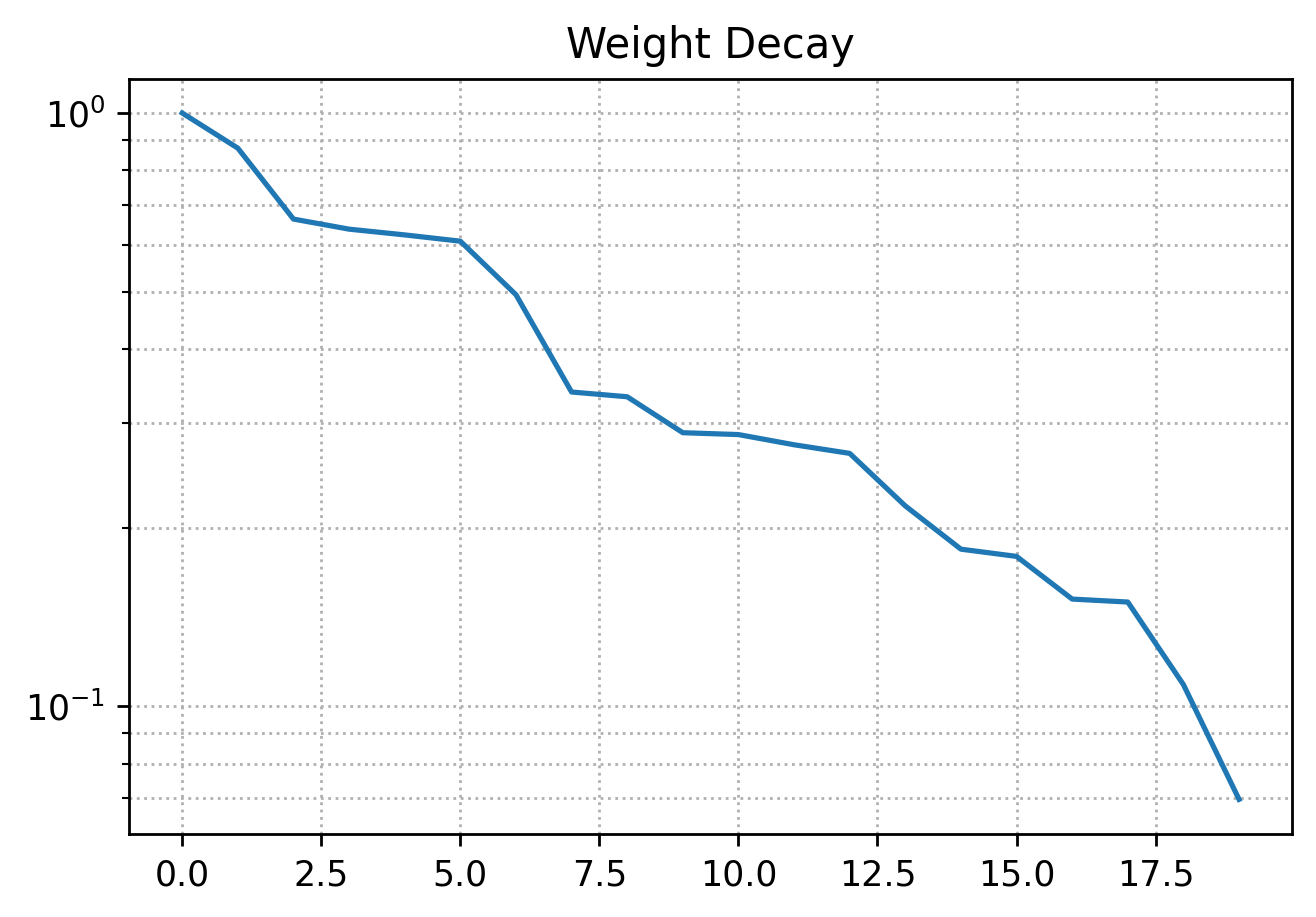

In [28]:
idx_data = 134
input_function_test_n = input_function_test[idx_data, :].reshape(1, -1)
output_function_test_n = output_function_test[idx_data, :].reshape(1, -1)
# Compute weights and basis functions
basis = trunk(y)
weights = branch(input_function_test_n)
output_function_test_pred_n = deeponet(input_function_test_n, y)

idx_sorted = torch.argsort(torch.abs(weights[0, :]), descending=True)
weights = weights[0, idx_sorted]
basis = basis[:, idx_sorted]
plt.figure(dpi=250)
plt.grid(True, which="both", ls=":")

color = (abs(weights) / max(abs(weights)))
idx_y_sorted = np.argsort(y.detach().numpy().reshape(-1, ))

for i in range(basis.shape[1]):
    plt.plot(y[idx_y_sorted].detach(), basis[idx_y_sorted, i].detach(), lw=color[i], c="C" + str(i + 1))

plt.plot(y[idx_y_sorted].detach(), output_function_test_n.T[idx_y_sorted].detach(), label="True Solution", c="C0", lw=2)
plt.scatter(y[idx_y_sorted].detach(), output_function_test_pred_n.T[idx_y_sorted].detach(), label="Approximate Solution", s=8, c="C0")
p = 2
err = (torch.mean(abs(output_function_test_n.detach().reshape(-1, ) - output_function_test_pred_n.detach().reshape(-1, )) ** p) / torch.mean(abs(output_function_test_n.detach()) ** p)) ** (1 / p) * 100
print("Relative L2 error: ", err.item())
plt.legend()

plt.figure(dpi=250)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(0, color.shape[0]), color.detach())
plt.title("Weight Decay")
plt.yscale("log")
plt.show()